# 1.0 Data Wrangling

## Foundations of Spatial Data Science - CASA0013

### Group Project - Policy Brief

In [1]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


## 1.1 Calculating Rate of Professional AirBnB hosts by LSOA

### 1.1.1 Read in data

In [2]:
# Reading in listings data
listings = gpd.read_feather("data/2022-09-10-listings.geofeather")

In [3]:
#Reading in the Lower Super Output Area (LSOA) shapefile
lsoa = gpd.read_file("data/boundaries/LSOA_2004_London_Low_Resolution.shp")

### 1.1.2 Identify professional listings

In [4]:
#Converting the total_listing_count column to numpy array for manipulation
host_count = np.array(listings['host_total_listings_count'].values.tolist())

In [5]:
host_count[host_count > 1] = 0 #Changing any values above 1 to 0. Meaning "not casual" (professional).

In [6]:
listings['casual'] = host_count #Creating a new column which identifies if a listings host is casual (1 listing), or professional (>1 listing)



|  | Professional | Non-Professional (Casual)|
| --- | --- | --- |
| **Listing Count** | > 1 |1 |

### 1.1.3 Convert to same CRS

In [7]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
listings = listings.to_crs(lsoa.crs)

### 1.1.4 Spatial Join listings to LSOAs (spatial aggregation unit)

In [8]:
#Spatially joining the LSOA to each listing
lsoa_ls = listings.sjoin(lsoa, predicate="within")

In [9]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_ls["count"] = 1
professinal_count = lsoa_ls.groupby(["LSOA_CODE", "casual"])["count"].sum().reset_index()

In [10]:
host_lsoa = professinal_count.groupby("LSOA_CODE")["count"].sum().reset_index() #Total number of hosts per LSOA

In [11]:
#Identifying hosts that are professional (more than one listing)
prop_count = professinal_count[professinal_count["casual"] ==0].rename(columns={"count":"professional_count"}).merge(host_lsoa.rename(columns={"count":"total_count"}), on="LSOA_CODE", how="right")

In [12]:
#Calculating the proportion of professional AirBnB hosts to total hosts per LSOA
prop_count["prop"] = prop_count["professional_count"] / prop_count["total_count"]

In [13]:
#Merging this proportion with the overall spatially referenced LSOA data
lsoa_prop = lsoa.merge(prop_count, how="left", on="LSOA_CODE")

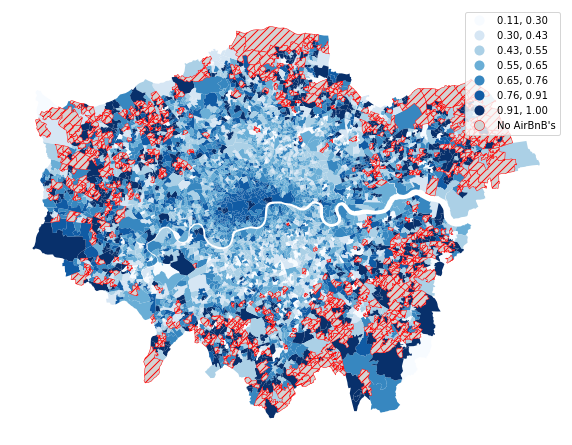

In [14]:
#An inital map identifying rates of professionalisation of AirBnB across London
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_prop.plot(column="prop", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues",
               missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5))

plt.axis("off")

plt.savefig("figures/proportion_of_professional_hosts.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()